# Miniproyecto 2 - Modelos de Variable Latente para el Reconocimiento de Emociones

**Autores:**  
* Jackeline Morales Hernandez

* Jose David Ortiz Miranda

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**



In [1]:
## Librerias importantes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


1.Para el sistema de Análisis Multivariado de Señales fisiológicas obtenido en el Primer Mini-Proyecto, se debe
construir un módulo de variable latente utilizando el algoritmo de PCA. La idea es proyectar la matriz característica
obtenida $X \in \mathbb{R}^{N \times D}$, a un espacio latente de menor dimensión $q << D$, de tal forma que los nuevos datos en este
espacio sean $Z \in \mathbb{R}^{N \times q}$. Seleccione diferentes configuraciones del número de componentes q y evalúe el mejor
desempeño arrojado por el modelo midiendo el accuracy y la matriz de confusión. Para ello:



a) Realice la visualización de las componentes en el espacio latente para diferentes configuraciones de q

In [2]:
dataframe=pd.read_pickle("./dataframe_minip1.pkl")
ultima_columna = dataframe.iloc[:, -1]
ultima_columna = ultima_columna.values.reshape(-1, 1) #etiqueta
data=dataframe.values[:,0:-1]
Y=ultima_columna
scaler = StandardScaler()
data_normalizada = scaler.fit_transform(data)
X=data_normalizada
target=dataframe['Emocion']
unique_labels, counts = np.unique(Y, return_counts=True)

# Imprimir los resultados
for label, count in zip(unique_labels, counts):
    print(f'Número de {label}s: {count}')

Número de 0.0s: 62
Número de 1.0s: 62
Número de 2.0s: 36


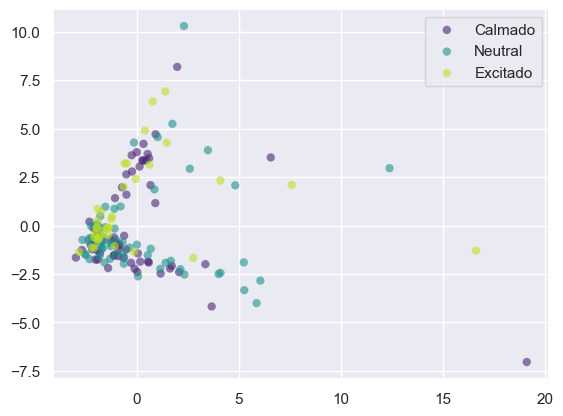

In [3]:
n_componentes=3
pca = PCA(n_components = n_componentes)  # project from 64 to 2 dimensions

#X = dataframe.data # Load our dataset X
projectedZ = pca.fit_transform(X )
viridis_colors = [cm.viridis(x) for x in [0.1, 0.5, 0.9]]
colors = viridis_colors
label_mapping = {0: 'Calmado', 1: 'Neutral', 2: 'Excitado'}
for label in range(3):
    plt.scatter(
        projectedZ[np.squeeze(ultima_columna) == label, 0],
        projectedZ[np.squeeze(ultima_columna) == label, 1],
        c=[viridis_colors[label]],
        edgecolor='none',
        alpha=0.6,
        label=f'{label_mapping[label]}'
    )
plt.legend()
plt.show()


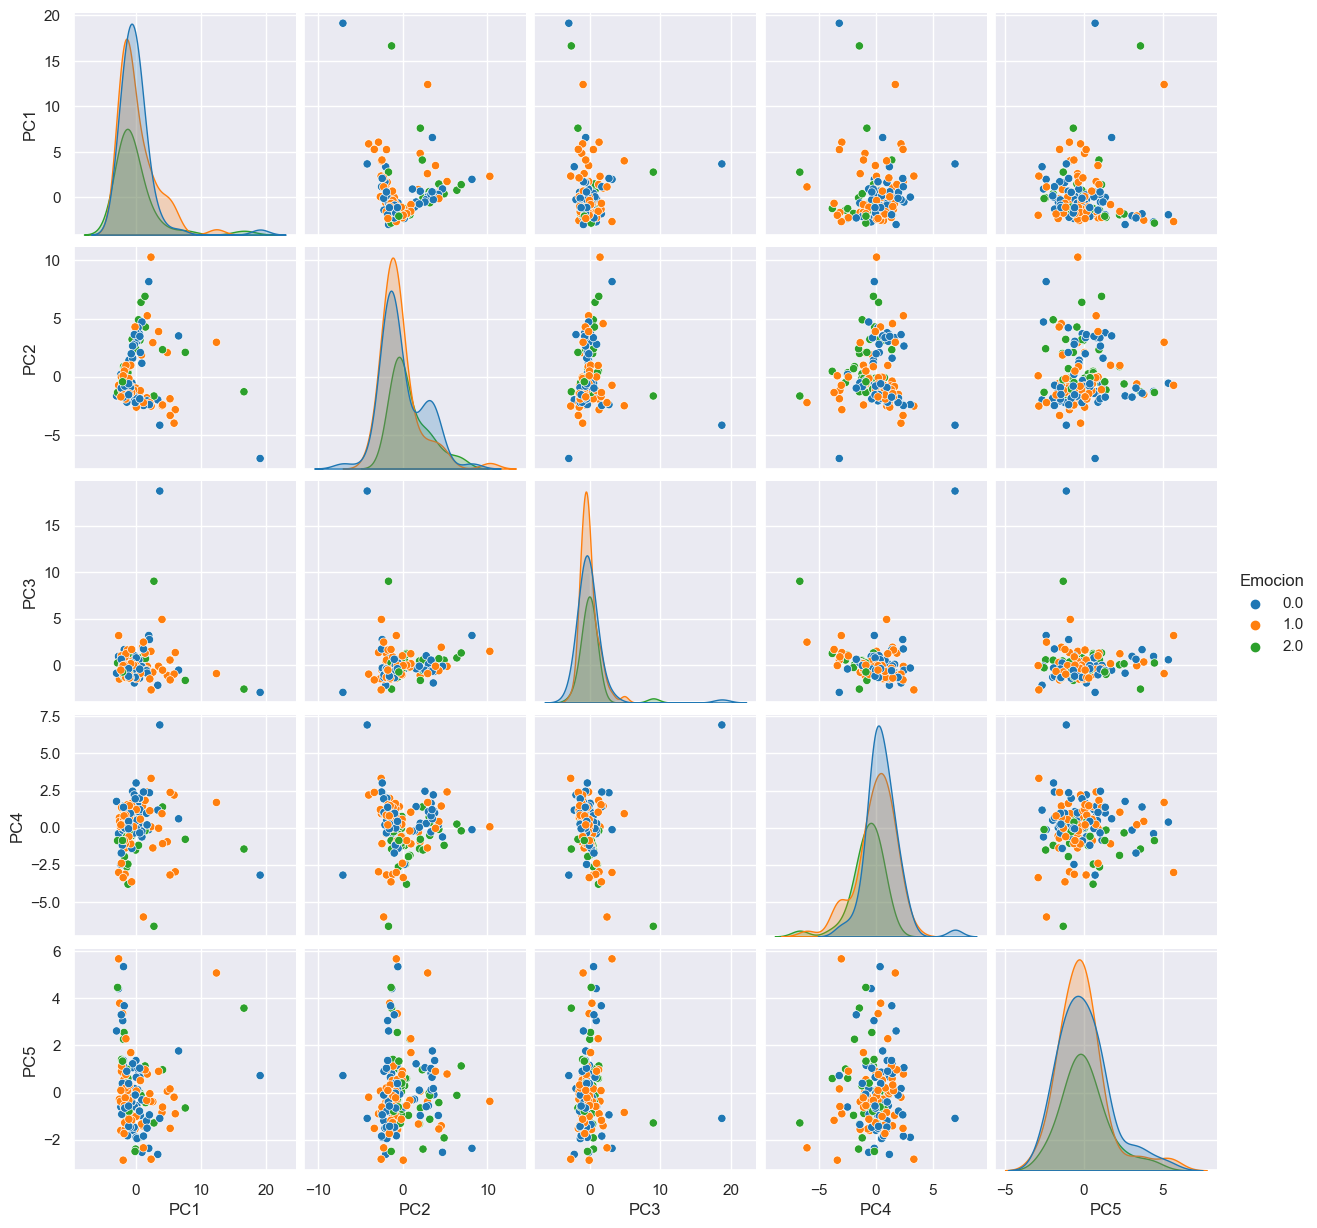

In [4]:
pca1 = PCA(n_components = 5)  # project from 64 to 2 dimensions

projectedZ1 = pca1.fit_transform(X)
X_prueba = projectedZ1[:,:5]
y = ultima_columna

#dataFrame = pd.DataFrame(X_prueba,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])
dataFrame = pd.DataFrame(X_prueba,columns=['PC1','PC2','PC3','PC4','PC5'])
dataFrame['Emocion'] = y
sns.pairplot(dataFrame, hue='Emocion', palette='tab10')

- Entrene un modelo lineal de clasificacion Mínimos Cuadrados, Bayesiano y Regresión Logística, con el
fin de evaluar el desempeño en el reconocimiento de los tipos de movimiento tanto en el espacio de entrada
(sin utilizar PCA), cómo en el espacio latente.

In [5]:
def modelos(X,Y):

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
  y_train = y_train.ravel()
  y_test = y_test.ravel()
  # ---------------- Regresión Logística ----------------------------------------------------------
  clf = LogisticRegression(penalty='l2', random_state=0, C=1,max_iter=16000).fit(X_train, y_train)
  y_pred_LR_train = clf.predict(X_train)
  y_pred_LR_test = clf.predict(X_test)
  accTrain = accuracy_score(y_train, y_pred_LR_train)
  print('Accuracy Train para regresión logística: ', accTrain)
  accTest = accuracy_score(y_test, y_pred_LR_test)
  print('Accuracy Test para regresión logística: ', accTest)
  cMat_test_LR = confusion_matrix(y_test, y_pred_LR_test)

  # ---------------- Modelo Bayesiano ----------------------------------
  gnb = GaussianNB()
  y_pred_NB = gnb.fit(X_train, y_train).predict(X_test)
  y_pred_train_NB = gnb.fit(X_train, y_train).predict(X_train)
  accTrain_NB = accuracy_score(y_train, y_pred_train_NB)
  print('Accuracy Train para modelo bayesiano: ', accTrain_NB)
  accTest_NB = accuracy_score(y_test, y_pred_NB)
  print('Accuracy Test para modelo bayesiano: ', accTest_NB)
  cMat_test_NB = confusion_matrix(y_test, y_pred_NB)

  #----------------------------Minimos cuadrados -----------------------------------
  T1 = np.tile([1.,0.,0.],(62,1))
  T2 = np.tile([0.,1.,0.],(62,1))
  T3 = np.tile([0.,0.,1.],(36,1))
  T = np.concatenate((T1,T2,T3),axis = 0)
  X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.3, random_state=0)
  Y_train=np.argmax(y_train, axis=1)
  Y_test=np.argmax(y_test, axis=1)
  # Como el modelo compacto tiene Xtilde, debemos concatenar un vector 1s en la primer columna
  Xtilde_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
  Xtilde_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)

  XtildeT_train = Xtilde_train.T

  # Calcular el modelo que tiene wk_tilde por cada columna relacionada a una clase
  Wtilde = np.linalg.inv(XtildeT_train @ Xtilde_train) @ (XtildeT_train @ y_train)

  # Predicciones de entrenamiento
  Y_est_train = Xtilde_train @ Wtilde

  # Predicciones de prueba
  Xtilde_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
  Y_est_test = Xtilde_test @ Wtilde

  # Obtener las etiquetas predichas
  y_pred_train = np.argmax(Y_est_train, axis=1)
  y_pred_test = np.argmax(Y_est_test, axis=1)

  # Calcular la exactitud
  accTrain = accuracy_score(Y_train, y_pred_train)
  print('Accuracy Train para minimos cuadrados: ', accTrain)
  accTest = accuracy_score(Y_test, y_pred_test)
  print('Accuracy Test para minimos cuadrados: ', accTest)
  cMat_test_cu = confusion_matrix(Y_test,y_pred_test)


  return cMat_test_LR,cMat_test_NB,cMat_test_cu

In [6]:
def graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu ):
  emociones_uniques = target.unique()
  # Dividir los datos en conjuntos de entrenamiento y prueba
  fig, axes = plt.subplots(1,3, figsize=(18, 5))
  # Matriz de confusión para Regresión Logística
  ax1 = axes[0]
  disp_LR = ConfusionMatrixDisplay(cMat_test_LR, display_labels=emociones_uniques)
  disp_LR.plot(ax=ax1)
  ax1.set_title("Matriz de confusión regresión logística")
  ax1.grid(False)

  # Matriz de confusión para Modelo Bayesiano
  ax2 = axes[1]
  disp_NB = ConfusionMatrixDisplay(cMat_test_NB, display_labels=emociones_uniques)
  disp_NB.plot(ax=ax2)
  ax2.set_title("Matriz de confusión modelo bayesiano")
  ax2.grid(False)

  # Matriz de confusión para minimos cuadrados
  ax3 = axes[2]
  disp_cu = ConfusionMatrixDisplay(cMat_test_cu, display_labels=emociones_uniques)
  disp_cu.plot(ax=ax3)
  ax3.set_title("Matriz de confusión minimos cuadrados")
  ax3.grid(False)
  plt.show()

## **Sin usar PCA**

Accuracy Train para regresión logística:  0.9107142857142857
Accuracy Test para regresión logística:  0.5416666666666666
Accuracy Train para modelo bayesiano:  0.5803571428571429
Accuracy Test para modelo bayesiano:  0.3958333333333333
Accuracy Train para minimos cuadrados:  0.9642857142857143
Accuracy Test para minimos cuadrados:  0.8125


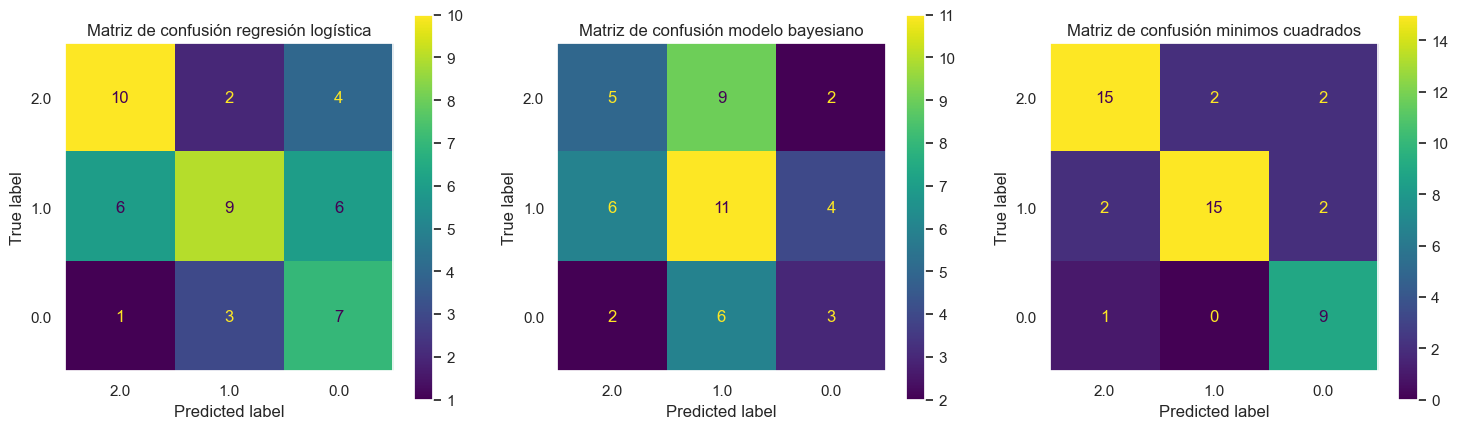

In [7]:
cMat_test_LR,cMat_test_NB,cMat_test_cu = modelos(X,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)

##  **Usando PCA**



### 10 componentes

Accuracy Train para regresión logística:  0.5982142857142857
Accuracy Test para regresión logística:  0.4375
Accuracy Train para modelo bayesiano:  0.48214285714285715
Accuracy Test para modelo bayesiano:  0.4166666666666667
Accuracy Train para minimos cuadrados:  0.75
Accuracy Test para minimos cuadrados:  0.6666666666666666


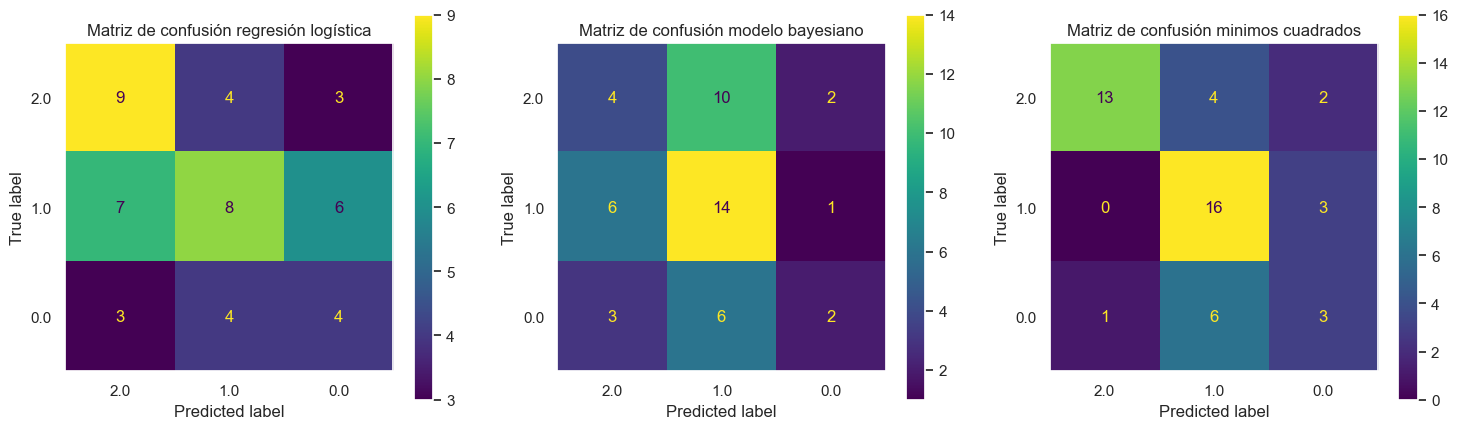

In [8]:
pca = PCA(n_components = 10)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)

### 20 componentes

Accuracy Train para regresión logística:  0.7232142857142857
Accuracy Test para regresión logística:  0.5625
Accuracy Train para modelo bayesiano:  0.6696428571428571
Accuracy Test para modelo bayesiano:  0.4583333333333333
Accuracy Train para minimos cuadrados:  0.9196428571428571
Accuracy Test para minimos cuadrados:  0.8125


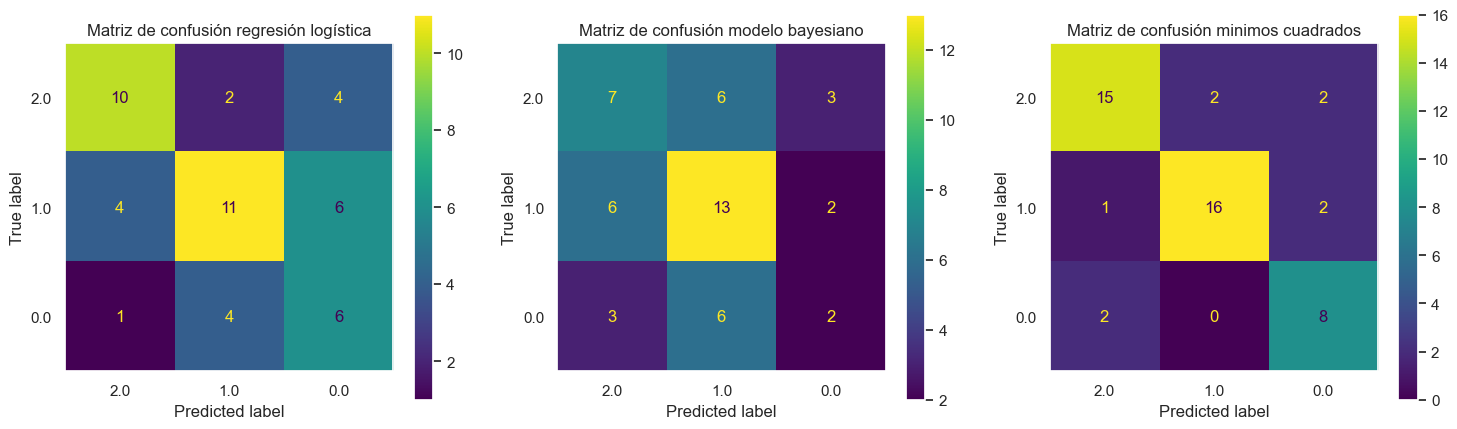

In [9]:
pca = PCA(n_components = 20)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)

### 30 componentes

Accuracy Train para regresión logística:  0.8303571428571429
Accuracy Test para regresión logística:  0.5
Accuracy Train para modelo bayesiano:  0.7410714285714286
Accuracy Test para modelo bayesiano:  0.3958333333333333
Accuracy Train para minimos cuadrados:  0.9642857142857143
Accuracy Test para minimos cuadrados:  0.8125


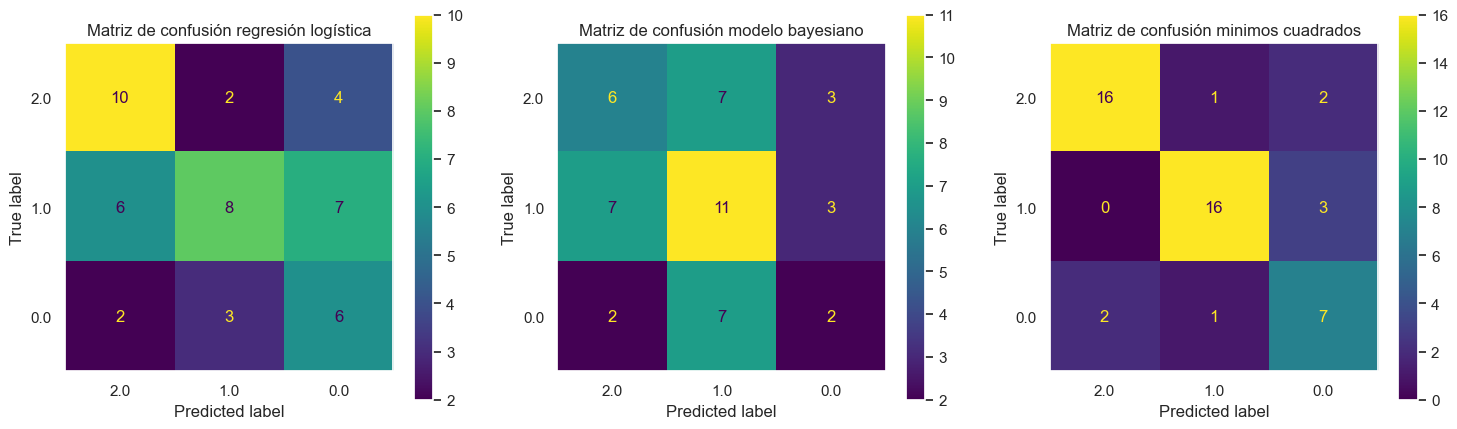

In [10]:
pca = PCA(n_components = 30)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)

### 40 componentes

Accuracy Train para regresión logística:  0.8660714285714286
Accuracy Test para regresión logística:  0.5416666666666666
Accuracy Train para modelo bayesiano:  0.8392857142857143
Accuracy Test para modelo bayesiano:  0.4166666666666667
Accuracy Train para minimos cuadrados:  0.9642857142857143
Accuracy Test para minimos cuadrados:  0.75


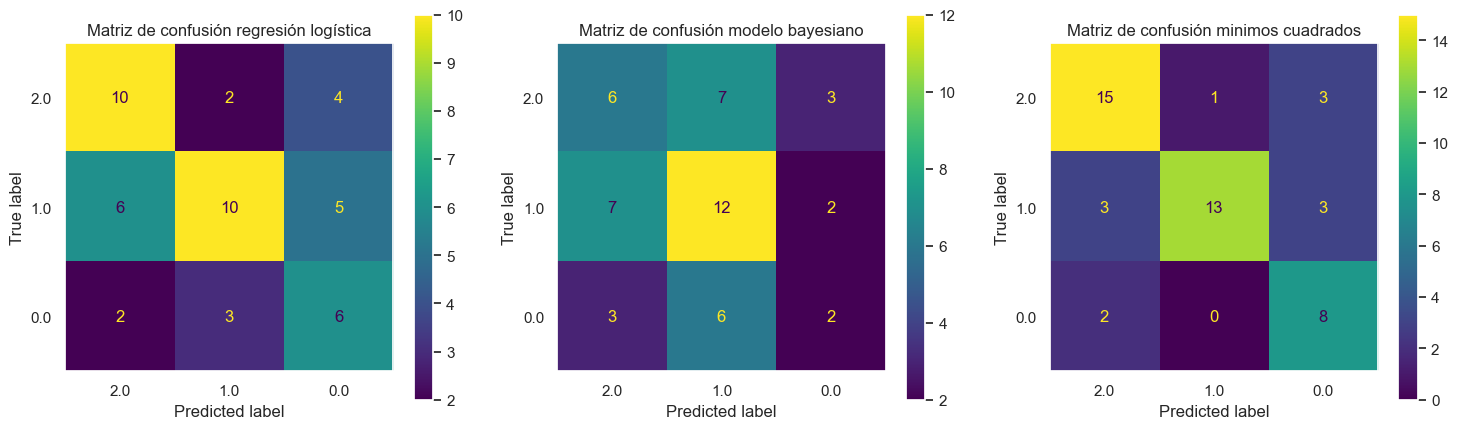

In [11]:
pca = PCA(n_components = 40)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)

### 50 componentes

Accuracy Train para regresión logística:  0.9107142857142857
Accuracy Test para regresión logística:  0.5416666666666666
Accuracy Train para modelo bayesiano:  0.7946428571428571
Accuracy Test para modelo bayesiano:  0.4583333333333333
Accuracy Train para minimos cuadrados:  0.9732142857142857
Accuracy Test para minimos cuadrados:  0.8333333333333334


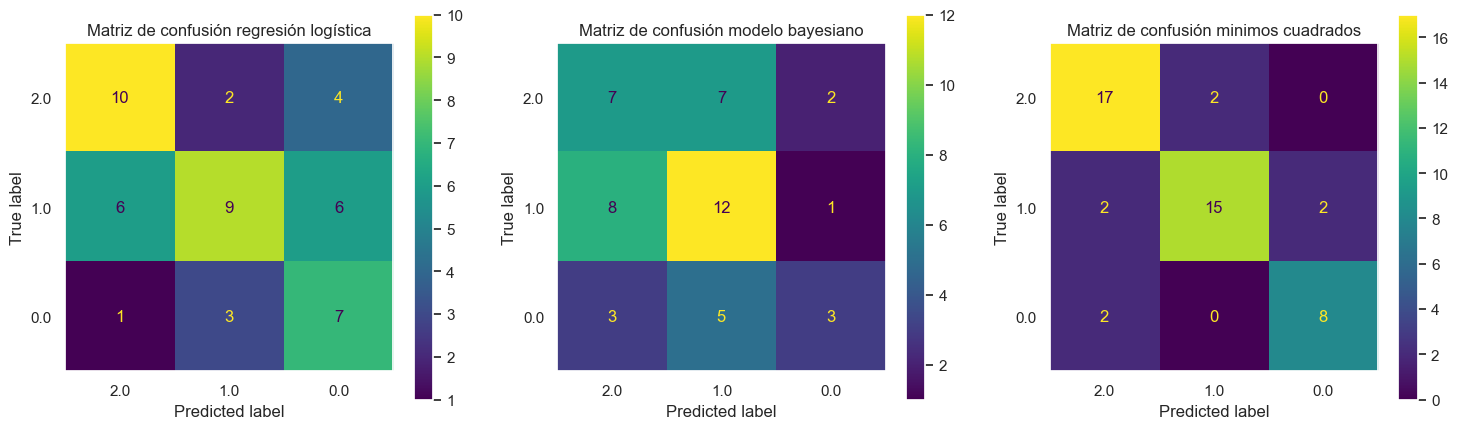

In [12]:
pca = PCA(n_components = 50)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)

2.Kernel PCA: Reducción de Dimensionalidad No Lineal

Dado que PCA es un modelo lineal de variable latente en el cual las características son mapeadas de la forma $z = Wx$, en muchas aplicaciones reales las relaciones entre los datos son no lineales. Es por esto que modelos como la reducción de la dimensionalidad a través del uso de funciones de mapeo (kernel) no lineales pueden ayudarnos en la tarea. Aquí, el mapeo se realiza utilizando $z = \Phi(x)$, donde $\Phi$ es la matriz de mapeo no lineal conocida como función de kernel.

Estas funciones de kernel pueden tener diferentes naturalezas como lineales, exponenciales, polinomiales, entre otras. Su objetivo aquí es realizar el procedimiento de mapeo del dataset de movimientos utilizando Kernel PCA (Kernel Principal Component Analysis).

En términos matemáticos, el proceso de mapeo no lineal se puede expresar como: $z = \Phi(x)$

